# RCT statistical analysis
<p>This workbook contains Python code for analysing a randomised controlled trial (RCT) in which participants with type 2 diabetes were randomized to one of two groups: "Control" (placebo) or "Treatment" (a glucose-lowering drug). In both groups, blood glucose ("BloodGlucose") was measured before and after 12 weeks.</p>
<p>The data is fictional and was simulated.</p>
<p>The null hypothesis was that there is no difference between the effect of treatment and the effect of control on blood glucose. The alternate hypothesis was that treatment improves (lowers) blood glucose more than control.</p>
<p>The following statistical approaches were used to compare between group changes in blood glucose:</p>
<ul>
<li>Two-way repeated-measures ANOVA.</li>
<li>Linear mixed modeling.</li>
<li>Bayesian modeling.</li>
</ul>

# Install packages

In [1]:
# python version
!python --version

Python 3.11.12


In [2]:
# load packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# load data

In [3]:
# Use a power calculation to determine the sample size for a randomized controlled trial in which a two-way ANOVA will be used to assess the change in BloodGlucose in adults with type 2 diabetes before and after taking a diabetes drug or placebo for 12 weeks. So, the ANOVA will have main effect of time (pre, post), main effect of group (drug, placebo), and their interactions. The expected effect size for this change is Cohen's D = 0.4. Assume an equal number of participants per group. Include consideration for an attrition rate of 10%.

import statsmodels.stats.power as smp

# Define parameters
effect_size = 0.4  # Cohen's d
alpha = 0.05       # Significance level
power = 0.80       # Desired power
attrition_rate = 0.10 # Attrition rate

# Account for attrition
n_per_group_unadjusted = smp.FTestAnovaPower().solve_power(effect_size=effect_size,
                                                        alpha=alpha,
                                                        power=power,
                                                        k_groups=2, # 2 groups (drug, placebo)
                                                        nobs=None) # Solve for nobs (sample size)

n_per_group = int(n_per_group_unadjusted / (1 - attrition_rate))

# Calculate total sample size
total_sample_size = n_per_group * 2 # 2 groups * samples per group

print(f"Unadjusted sample size per group: {n_per_group_unadjusted:.2f}")
print(f"Adjusted sample size per group (accounting for {attrition_rate*100:.0f}% attrition): {n_per_group}")
print(f"Total sample size: {total_sample_size}")

Unadjusted sample size per group: 51.05
Adjusted sample size per group (accounting for 10% attrition): 56
Total sample size: 112


In [4]:
# simulate data in a long format dataframe (df) for a randomized controlled trial of people ('ID') randomized to one of two groups: 'Control' and 'Treatment'. 'BloodGlucose' should be measured at two time points ('Time': Baseline and Week12). There should be 112 people in total, 56 in Control and 56 in Treatment. Each participant should have one 'BloodGlucose' measurement at Baseline and one at Week12. BloodGlucose values should range from 7 to 14 and should increase by approximately 0.5 in the Control group and decrease by approximately 1 in the Treatment group. There should be approximately a 10% attrition rate, i.e. Week12 BloodGlucose values should be missing for approximately 10% of the observations.

# Set random seed for reproducibility
np.random.seed(42)

# Total number of participants
n_total = 112
n_per_group = n_total // 2  # 56 per group

# Create participant IDs and assign groups
IDs = np.arange(1, n_total + 1)
groups = ['Control'] * n_per_group + ['Treatment'] * n_per_group
df_participants = pd.DataFrame({'ID': IDs, 'Group': groups})

# Simulate baseline BloodGlucose uniformly between 7 and 14 for each participant
baseline_glucose = np.random.uniform(7, 14, size=n_total)

# Create a dataframe for baseline measurements
df_baseline = df_participants.copy()
df_baseline['Time'] = 'Baseline'
df_baseline['BloodGlucose'] = baseline_glucose

# For Week12, simulate change according to group:
#   Control: increase by ~0.5 (plus some small noise)
#   Treatment: decrease by ~1 (plus some small noise)
noise_control = np.random.normal(0, 0.2, size=n_per_group)
noise_treatment = np.random.normal(0, 0.2, size=n_per_group)

week12_glucose_control = baseline_glucose[:n_per_group] + 0.5 + noise_control
week12_glucose_treatment = baseline_glucose[n_per_group:] - 1 + noise_treatment

# Ensure values stay within the range [7, 14]
week12_glucose_control = np.clip(week12_glucose_control, 7, 14)
week12_glucose_treatment = np.clip(week12_glucose_treatment, 7, 14)

# Combine the Week12 glucose values
week12_glucose = np.concatenate([week12_glucose_control, week12_glucose_treatment])

# Introduce a ~10% attrition rate for Week12 measurements
attrition_mask = np.random.rand(n_total) < 0.10  # about 10% will be True (missing)
week12_glucose[attrition_mask] = np.nan  # set those to missing

# Create a dataframe for Week12 measurements
df_week12 = df_participants.copy()
df_week12['Time'] = 'Week12'
df_week12['BloodGlucose'] = week12_glucose

# Combine the baseline and Week12 dataframes into a long format dataframe
df = pd.concat([df_baseline, df_week12], ignore_index=True)

# Optionally, sort the dataframe by ID and Time for clarity
df = df.sort_values(by=['ID', 'Time']).reset_index(drop=True)

# Display the first few rows of the simulated dataframe
print(df.head())

   ID    Group      Time  BloodGlucose
0   1  Control  Baseline      9.621781
1   1  Control    Week12     10.304861
2   2  Control  Baseline     13.655000
3   2  Control    Week12     14.000000
4   3  Control  Baseline     12.123958


# Exploratory data analysis

In [5]:
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            224 non-null    int64  
 1   Group         224 non-null    object 
 2   Time          224 non-null    object 
 3   BloodGlucose  207 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.1+ KB
None
               ID  BloodGlucose
count  224.000000    207.000000
mean    56.500000     10.129446
std     32.402735      2.108440
min      1.000000      7.000000
25%     28.750000      8.269992
50%     56.500000      9.872680
75%     84.250000     11.926776
max    112.000000     14.000000


## Identify and deal with missing values

In [6]:
# Quantify the number of missing values
df.isna().sum()

,0
ID,0
Group,0
Time,0
BloodGlucose,17


In [7]:
# Drop rows with missing values in the 'BloodGlucose' column
df = df.dropna(subset=['BloodGlucose'])
print(df.isna().sum())

ID              0
Group           0
Time            0
BloodGlucose    0
dtype: int64


## Identify outliers

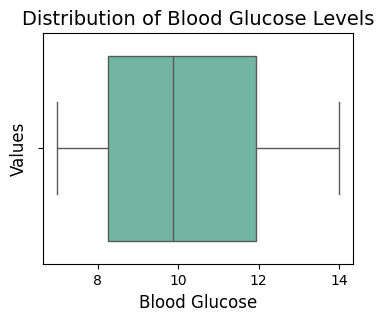

In [8]:
# Identify outliers by visualising the distribution of BloodGlucose with a boxplot. Use color-blind friendly colors

# Create the boxplot
plt.figure(figsize=(4, 3))
sns.boxplot(x='BloodGlucose', data=df, color='#66c2a5') #Color-blind friendly color

# Customize the plot
plt.title('Distribution of Blood Glucose Levels', fontsize=14)
plt.xlabel('Blood Glucose', fontsize=12)
plt.ylabel('Values', fontsize=12)

plt.show()

In [9]:
# Use the IQR method to remove outliers

# Calculate Q1, Q3, and IQR
Q1 = df['BloodGlucose'].quantile(0.25)
Q3 = df['BloodGlucose'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['BloodGlucose'] < lower_bound) | (df['BloodGlucose'] > upper_bound)]

# Remove outliers
df_no_outliers = df[(df['BloodGlucose'] >= lower_bound) & (df['BloodGlucose'] <= upper_bound)]

# Display the number of outliers removed
print(f"Number of outliers removed: {len(outliers)}")

Number of outliers removed: 0


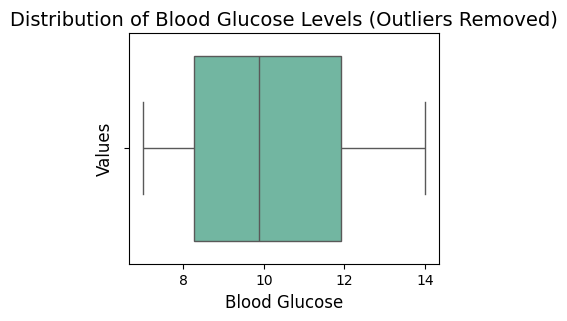

In [10]:
# Re-examine the boxplot without outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x='BloodGlucose', data=df_no_outliers, color='#66c2a5') #Color-blind friendly color

# Customize the plot
plt.title('Distribution of Blood Glucose Levels (Outliers Removed)', fontsize=14)
plt.xlabel('Blood Glucose', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.show()

## Test for normality and homogeneity of variance

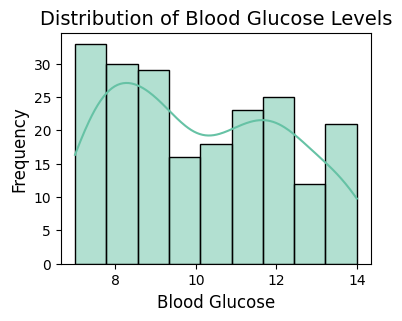

In [11]:
# Visualise the distribution of BloodGlucose with a histogram
plt.figure(figsize=(4, 3))
sns.histplot(df['BloodGlucose'], kde=True, color='#66c2a5')  #Color-blind friendly color
plt.title('Distribution of Blood Glucose Levels', fontsize=14)
plt.xlabel('Blood Glucose', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

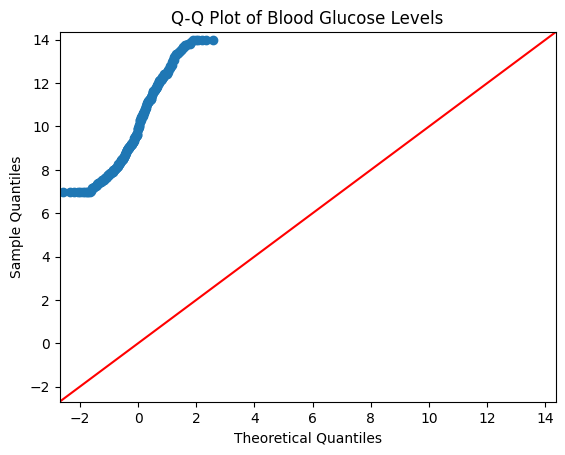

In [12]:
# Visualise the distribution of residuals with a Q-Q plot
from statsmodels.graphics.gofplots import qqplot # Import qqplot from the correct submodule
qqplot(df['BloodGlucose'], line='45')
plt.title('Q-Q Plot of Blood Glucose Levels')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [13]:
# test BloodGlucose for normality using shapiro wilks test

# Test for normality using Shapiro-Wilk test
from scipy.stats import shapiro

# Assuming 'df' is your DataFrame and 'BloodGlucose' is the column
stat, p = shapiro(df['BloodGlucose'].dropna()) # Drop NA values for the test

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.944, p=0.000
Sample does not look Gaussian (reject H0)


In [14]:
# test BloodGlucose for homogeneity of variance using Bartlett's test if Shapiro-Wilk Test Statistic p-value>0.05 or use Levene's Test if Shapiro-Wilk Test Statistic p-value<0.05

# Test for homogeneity of variance

# Bartlett's test if Shapiro-Wilk p-value > 0.05
if p > alpha:
    stat, p_bartlett = scipy.stats.bartlett(df[df['Group'] == 'Control']['BloodGlucose'],
                                            df[df['Group'] == 'Treatment']['BloodGlucose'])
    print('Bartlett Test Statistics=%.3f, p=%.3f' % (stat, p_bartlett))
    if p_bartlett > alpha:
        print('Samples have equal variance (fail to reject H0)')
    else:
        print('Samples do not have equal variance (reject H0)')

# Levene's test if Shapiro-Wilk p-value < 0.05
else:
    # Remove NaN (missing) values before applying the Levene test
    control_data = df[df['Group'] == 'Control']['BloodGlucose'].dropna()
    treatment_data = df[df['Group'] == 'Treatment']['BloodGlucose'].dropna()

    stat, p_levene = scipy.stats.levene(control_data, treatment_data)
    print('Levene Test Statistics=%.3f, p=%.3f' % (stat, p_levene))

    if p_levene > alpha:
        print('Samples have equal variance (fail to reject H0)')
    else:
        print('Samples do not have equal variance (reject H0)')

Levene Test Statistics=0.681, p=0.410
Samples have equal variance (fail to reject H0)


<p>Data are not normally distributed so need to be transformed or scaled.</p>

## Log-transform data

In [15]:
# Create a new column with log-transformed blood glucose values
df_no_outliers['log_BloodGlucose'] = np.log(df_no_outliers['BloodGlucose'])

# Display the first few rows to verify the new column
print(df_no_outliers.head())

   ID    Group      Time  BloodGlucose  log_BloodGlucose
0   1  Control  Baseline      9.621781          2.264029
1   1  Control    Week12     10.304861          2.332616
2   2  Control  Baseline     13.655000          2.614106
3   2  Control    Week12     14.000000          2.639057
4   3  Control  Baseline     12.123958          2.495183


In [16]:
# Ensure Group and Time are categorical
df_no_outliers['Group'] = df_no_outliers['Group'].astype('category')
df_no_outliers['Time'] = df_no_outliers['Time'].astype('category')

# Check data types of columns in the DataFrame
df_no_outliers.dtypes

,0
ID,int64
Group,category
Time,category
BloodGlucose,float64
log_BloodGlucose,float64


# Statistical analysis